# Sonification of A Light Curve Using Astronify
## Motivation
I wanted to better understand the process of sonification relating to astronomical data, and whether or not I could achieve this with Python. After a quick search on Google, I discovered the `astronify` library. `astronify` is still in development, but at the moment we can sonify any time-series data. That is, any signal that changes over time. This notebook details an example of sonification using `astronify` and a transit of Wasp-12b captured by the 0.50 meter Baker-Nunn Telescope at the Rothney Astrophysical Observatory (RAO) on Janurary 18, 2023. 

All preprocessing and lightcurve extraction was completed using [an amazing piece of software called Tycho](https://www.tycho-tracker.com/). I then saved the light curve data to a CSV file called `wasp12b-lightcurve-data.csv`. This is the data we'll be working with in this notebook. 

## Setup

You'll need an installation of Anaconda to run Jupyter Notebooks with all the usual Python libraries. You'll also want to install `astronify` with pip (see instructions in the `astronify` docs). 

- [Astronify](https://astronify.readthedocs.io/en/latest/astronify/install.html)
- [Anaconda](https://www.anaconda.com/)

## Step 1: Imports and Data

In [26]:
import pandas as pd
from astropy.table import Table
from astronify.series import SoniSeries

from matplotlib import pyplot as plt

import numpy as np

In [2]:
wasp12b_transit = pd.read_csv('/home/erichess/Documents/UCalgary/Data/Lightcurves/wasp12b-lightcurve-data.csv')
wasp12b_transit

,JD,Mag,MagErr
0,2.459963e+06,11.369678,0.022537
1,2.459963e+06,11.336644,0.022251
2,2.459963e+06,11.330651,0.037001
3,2.459963e+06,11.352359,0.035700
4,2.459963e+06,11.363775,0.028331
...,...,...,...
115,2.459963e+06,11.360006,0.020400
116,2.459963e+06,11.337216,0.021478
117,2.459963e+06,11.352301,0.028984
118,2.459963e+06,11.357440,0.034647


### Subnote: Inverting Arrays
Data from exoplanets shows a dip in the star's brightness, which appears as an *increase* in magnitudes. Since `astronify`'s sonification algorithm scales audio frequencies to the data, this will result in *higher* frequencies generated during the planet's transit when the brightness of the star is *lower*. This is counterintuitive. 

To fix this, I've created a reliable way to invert an array so that the minimum values become maximums, and vice versa. This is coded into the `invert_array()` function below.

In [96]:
'''
The invert_array() function inverts an array so that maxima and minima swap while spanning the same range in values.
It takes one parameter:
- array: a numpy.array to invert
It returns one thing:
- arrayInverted: a numpy.array that represents the inverted 'array'
'''
def invert_array(array):
    arraySum = array.sum()
    arrayMin = array.min()
    
    # Step 1: Normalize the array
    arrayInverted = array / arraySum
    
    # Step 2: Invert the array
    arrayInverted = arrayInverted * -1
    
    # Step 3: Scale the inverted array back up
    arrayInverted = arrayInverted * arraySum
    
    # Step 4: Calculate the difference between the lowest point on the original array (always higher)
    # and the lowest point on the new, inverted array (always lower)
    arrayDiff = array.min() - arrayInverted.min()
    
    # Step 5: Shift the new, inverted array up by the arrayDiff
    arrayInverted = arrayInverted + arrayDiff
    
    return arrayInverted

### An example of inverting an array
Below I've created a small array of data that simulates what we'd see with an exoplanet transit. Notice how, just like with a real transit, the values on the y-axis increase during the actual transit. By passing this array into the `invert_array()` function, we obtain an array with the same shape, but where the 'dip' in the planet's brightness is inverted. 

Notice how we do this *without* inverting the y-axis.

In [105]:
dip = np.array([1,1.1,4.25,5,5,3.75,1.2,1])
dipInverted = invert_array(dip)
t = np.arange(0,8,1)

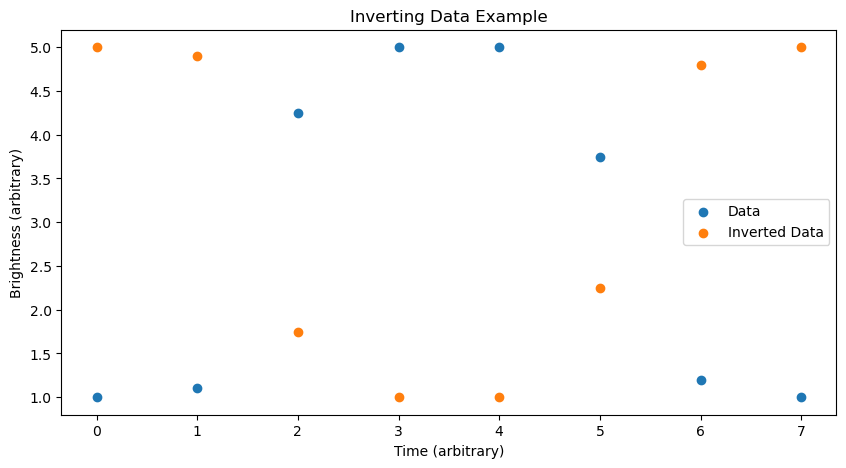

In [108]:
plt.figure(figsize=(10,5))
plt.title('Inverting Data Example')
plt.scatter(t, dip, label='Data')
plt.scatter(t,dipInverted, label='Inverted Data')

plt.xlabel('Time (arbitrary)')
plt.ylabel('Brightness (arbitrary)')
plt.legend()

plt.show()

See how the y-values span the same range on the graph, but maxima and minima have swapped? This has the same effect as calling `plt.gca().invert_yaxis()`, but with one key difference: `invert_array()` actually returns a mutated array, whereas `plt.gca().invert_yaxis()` does not mutate the data plotted --- it simply changes how the data is visualized on a graph. 

This will allow us to sonify our light curve in a way that matches our intuition:
- Brighter values are mapped to higher pitch
- Dimmer values are mapped to lower pitch

## Step 2: Visualizing the Transit Data
Now for the reason we're here! A common way to visualize a transit is with a lightcurve. This is a *visual* way to represent the data. We can do so with a standard plot using the actual data collect by the RAO from Wasp-12b. 

In [109]:
mags = np.array(wasp12b_transit['Mag'])
invertedMags = invert_array(mags)

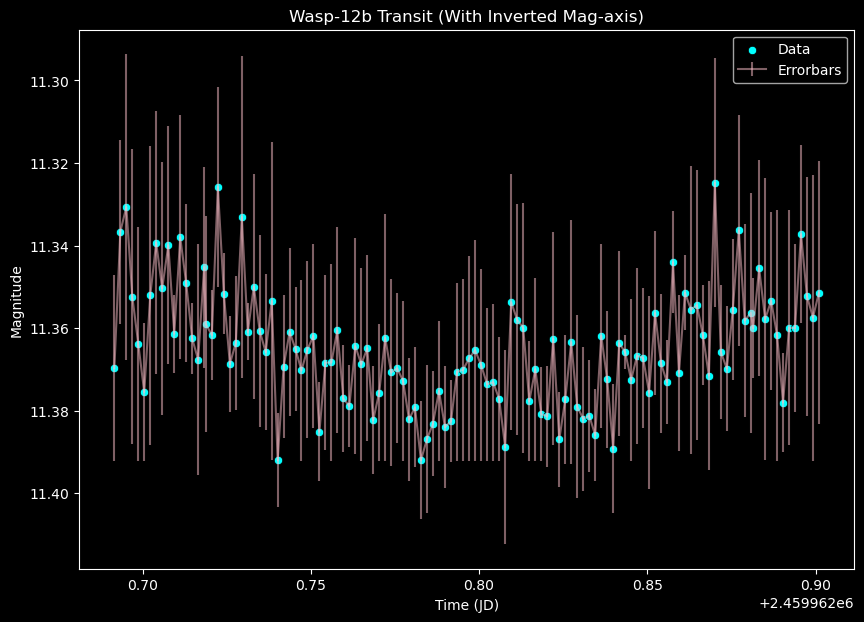

In [166]:
# plt.style.use('dark_background')
plt.figure(figsize=(10,7))
plt.title('Wasp-12b Transit (With Inverted Mag-axis)')

plt.errorbar(wasp12b_transit['JD'], mags, yerr=wasp12b_transit['MagErr'], c='pink', alpha=0.5, label='Errorbars')
plt.scatter(wasp12b_transit['JD'], mags, c='aqua', label='Data', edgecolors='black', linewidths=0.5)

plt.xlabel('Time (JD)')
plt.ylabel('Magnitude')

plt.legend()

plt.gca().invert_yaxis()

plt.savefig('/home/erichess/Documents/UCalgary/UCalgary_Code/UCalgary HTML-CSS-JS/Wasp-12b Sonification Website/Media/Wasp12b-lightcurve.png', dpi=300)

plt.show()

**Notice** how in the above graph we've inverted the magnitude-axis to show the traditional 'dip' in brightness, characteristic of a transit. Also notice how nice our data looks! Very cool.

## Step 3: Sonifying the Data
To sonify the data I'll use the inverted magnitude created using `invert_array()` and simply following the documentation from `astronify` here: [https://astronify.readthedocs.io/en/latest/astronify/index.html](https://astronify.readthedocs.io/en/latest/astronify/index.html)

The only difference I noticed was that the `.play()` method didn't work in my Jupyter notebook. This can likely be configured, but I opted to use the `.write()` method instead, specifying that I wanted an MP3 file. 

Another note is that you don't *have to* specify the `center_pitch` for the `pitch_mapper`. The music nerds reading this will notice that I simply chose A4 on a piano (i.e. the forth A-note from the left) because it seemed like a good medium value to use to avoid too many 'screeching' tones near the top end. Feel free to adjust. 

In [142]:
# Step 1: Create astropy.table of data to be sonified. 
# NOTE: Time column must be called 'time' and flux/mag/etc column must be called 'flux'
data_table = Table({'time':wasp12b_transit['JD'], 
                   'flux':invertedMags})

# Step 2: Initialize the SoniSeries object with the lightcurve data
data_soni = SoniSeries(data_table)

# Step 3: Specifying the note_spacing property for the SoniSeries object
# This is the space between notes played (one note per data point) in seconds.
# May need to adjust depending on the size of your data set
data_soni.note_spacing = 0.05

# Step 4: Sonify the data by calling the .sonify() method
data_soni.pitch_mapper.pitch_map_args["center_pitch"] = 440 
data_soni.sonify()

In [143]:
# Step 5: Play the sonified data
data_soni.write('/home/erichess/Documents/UCalgary/Data/Lightcurves/Sonifications/wasp12b-sonification.mp3')

Pyo message: Offline Server rendering file /home/erichess/Documents/UCalgary/Data/Lightcurves/Sonifications/wasp12b-sonification.mp3 dur=6.375028
Pyo message: Offline Server rendering finished.


## (Optional) Step 4: Simulating A Transit
Below I experimented with `astronify` to simulate a similar transit to the one we recorded. A mag difference from before transit to after transit of 0.03 maps to a change in brightness of 28 parts-per-thousand (ppt). The below example simulates a transit using the same depth over a slightly longer duration. 

**Note** that since this is a simulation it has much less noise. However, after listening to this it's much easier to identify the overall pattern in the sanification of data collected at the RAO, so it could be useful for teaching people what to listen for if it's the first time they're hearing a sonification.

To simulate exactly **one** transit, set the `transit_period` and `lc_length` values equal to one another. The parameters are adequetly described in the documentation here: [https://astronify.readthedocs.io/en/latest/api/astronify.simulator.simulated_lc.html#astronify.simulator.simulated_lc](https://astronify.readthedocs.io/en/latest/api/astronify.simulator.simulated_lc.html#astronify.simulator.simulated_lc)

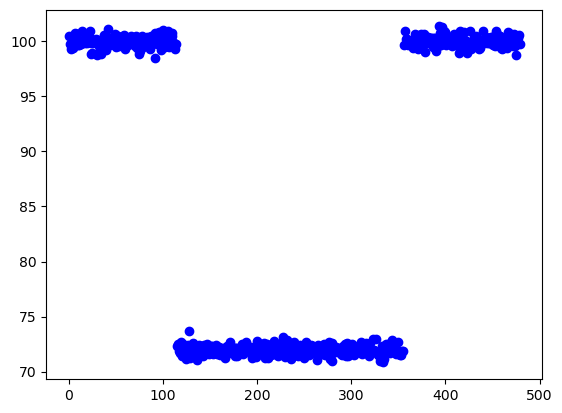

Pyo message: Offline Server rendering file /home/erichess/Documents/UCalgary/Data/Lightcurves/Sonifications/transit-sim-sonification.mp3 dur=5.290000
Pyo message: Offline Server rendering finished.


In [139]:
from astronify import simulator, series

lc_data = simulator.simulated_lc("transit", visualize=True, transit_depth=28.0, transit_start=115,
                                  transit_period=480, transit_width=240,
                                  lc_noise=0.5, lc_length=480)
soni_obj = series.SoniSeries(lc_data)
soni_obj.sonify()
soni_obj.write('/home/erichess/Documents/UCalgary/Data/Lightcurves/Sonifications/transit-sim-sonification.mp3')  

In [146]:
lc_data

time,flux,flux_pure
int64,float64,float64
0,100.5246650711462,100.0
1,99.7400332876674,100.0
2,99.29493620507444,100.0
3,100.4561825195438,100.0
4,99.3559602286194,100.0
5,100.12172428888054,100.0
6,100.59983276939249,100.0
7,100.77760874111523,100.0
8,100.65857728222583,100.0


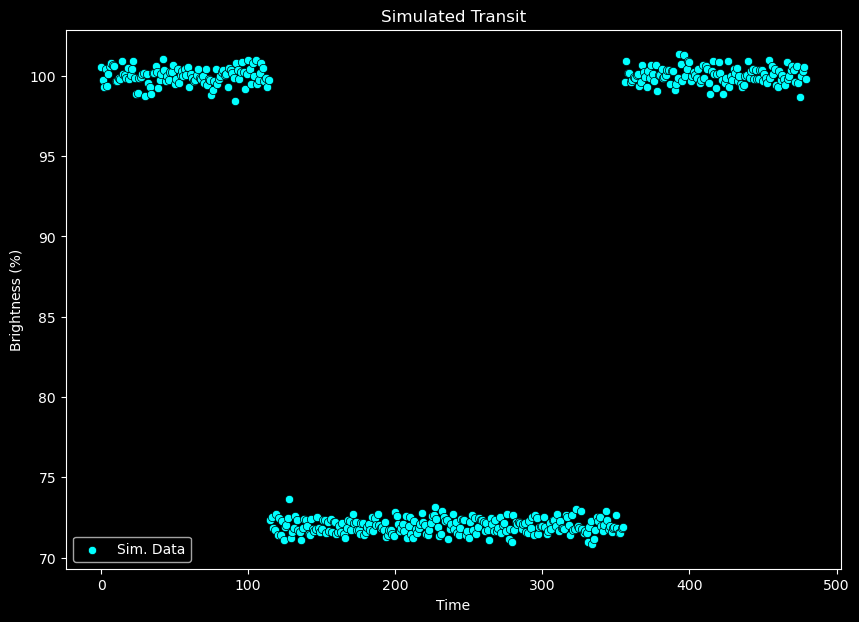

In [165]:
# plt.style.use('dark_background')
plt.figure(figsize=(10,7))

plt.title('Simulated Transit')

plt.scatter(lc_data['time'], lc_data['flux'], c='aqua', edgecolors='black', linewidths=0.5, label='Sim. Data')

plt.xlabel('Time')
plt.ylabel('Brightness (%)')

plt.legend()

plt.savefig('/home/erichess/Documents/UCalgary/UCalgary_Code/UCalgary HTML-CSS-JS/Wasp-12b Sonification Website/Media/simulated-transit.png', dpi=300)

plt.show()

## Closing Remarks
I hope this notebook helps folks get up to speed quickly with the sonification of data (specifically transit data) using Python. If you have any questions, feel free to get in touch!

- Eric